# Simple offset-free MPC example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from openmpc.filters import KF, KFParameters
from openmpc.models import LinearSystem
from openmpc.mpc import SetPointTrackingMPC, MPCProblem


# Define the system matrices
A = np.array([[0.95, -0.2],
              [0.2, 0.95]])
B = np.array([[0],
              [-0.2125]])
Bd = np.array([[0],
               [-0.2125]])
C = np.array([[1, 0]])
Cd = np.array([[0]])

D = np.array([[0]]) 

linear_system = LinearSystem(A, B, C, D, Bd, Cd)

# Define the cost matrices
Q = np.diag([100, 0])  # State penalty
R = np.array([[1]])  # Input penalty
T = 20  # Prediction horizon

# Create the MPC parameters object
mpc_params = MPCProblem(system = linear_system, horizon = T, Q = Q, R = R)

# Add input constraints (e.g., |u| <= 10)
mpc_params.add_input_magnitude_constraint(limit=10)

# Create the tracking MPC object
mpc_tracking = SetPointTrackingMPC(mpc_params)

# Kalman filter setup
Sigma_w  = np.eye(linear_system.size_state) * 0.01        # State covariance
Sigma_wd = np.eye(linear_system.size_disturbance) * 0.01  # Process noise covariance
Sigma_v  = np.eye(linear_system.size_output) * 0.1        # Measurement noise covariance



x0_est = np.array([0., 0.])  # Initial state estimate
P0_est = np.eye(2)         # Initial state covariance estimate
d0_est = np.array([0.])     # Initial disturbance estimate
P0d_est = np.eye(1)        # Initial disturbance covariance estimate

kf_params = KFParameters(system  = linear_system, 
                         Sigma_v = Sigma_v, 
                         Sigma_w = Sigma_w,
                         x0      = x0_est, 
                         P0      = P0_est)

kf_params.add_constant_disturbance_prediction(Sigma_wd = Sigma_wd, 
                                              d0       = d0_est, 
                                              P0d      = P0d_est)

kf  = KF(kf_params, is_stationary=True)


# Run the simulation
T_sim     = 200
x0        = np.array([0., 0.])  # Initial true state
reference = np.array([1.0])  # Constant reference

x_sim = np.zeros((2, T_sim + 1))
u_sim = np.zeros(T_sim)
reference_array = np.ones(T_sim)  # Array to store the reference values
x_sim[:, 0] = x0

# Disturbance profile: 0 for the first 100 steps, +1 for the remaining 100 steps
disturbance_array = np.zeros(T_sim)
disturbance_array[100:] = 1

for t in range(T_sim):
    current_state = x_sim[:, t]
    disturbance   = np.array([disturbance_array[t]])

    y_t = C @ current_state + Cd @ disturbance + np.random.normal(0, 0.01, size=linear_system.size_output)
    
    # Kalman filter measurement update
    kf.measurement_update(y_t, u_sim[t - 1] if t > 0 else np.array([0.]))

    # Get the state and disturbance estimates
    x_hat = kf.get_state_estimate()
    d_hat = kf.get_disturbance_estimate()

    # Get the control action based on estimated state and disturbance
    u_t      = mpc_tracking.get_control_action(x_hat, reference, d_hat)
    u_sim[t] = u_t

    # Update the true system dynamics
    x_sim[:, t + 1] = linear_system.discrete_dynamics(x= x_sim[:, t], u = u_t, d = disturbance)

    # Kalman filter prediction update
    kf.prediction_update(u_t)



/tmp/ipykernel_57489/3515640452.py:94: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_sim[t] = u_t


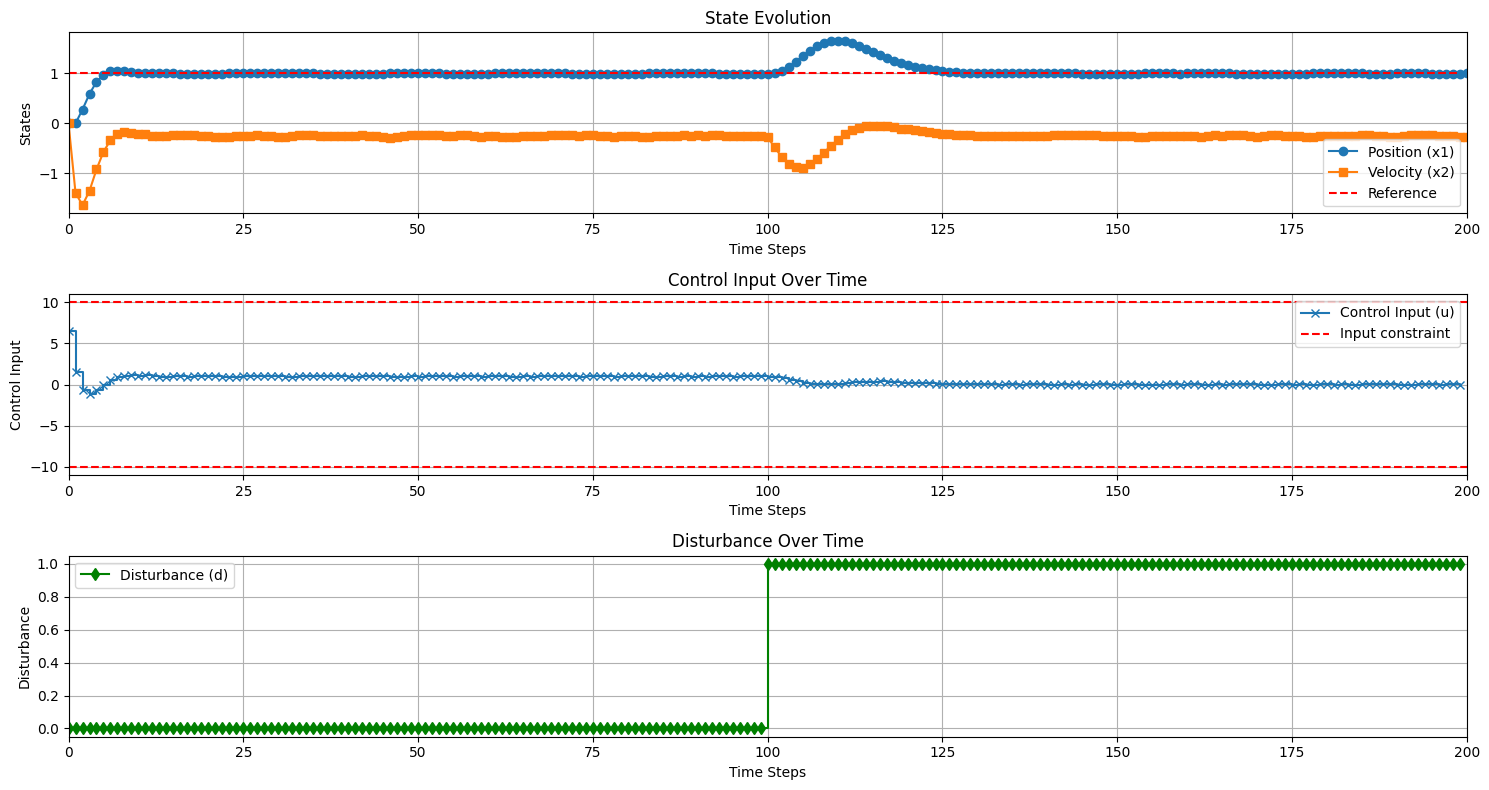

In [3]:

# Plotting the simulation results
time = np.arange(T_sim + 1)  # Time vector for states
time_u = np.arange(T_sim)  # Time vector for control input

plt.figure(figsize=(15, 8))

# Plot states
plt.subplot(3, 1, 1)
plt.plot(time, x_sim[0, :], label='Position (x1)', marker='o')
plt.plot(time, x_sim[1, :], label='Velocity (x2)', marker='s')
plt.step(time_u, reference_array, where='post', linestyle='--', color='r', label='Reference')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.title('State Evolution')
plt.legend()
plt.grid()
plt.xlim([0, T_sim])  # Set x-axis limits to start at 0

# Plot control input
plt.subplot(3, 1, 2)
plt.step(time_u, u_sim, where='post', label='Control Input (u)', marker='x')
plt.axhline(10, color='r', linestyle='--', label='Input constraint')
plt.axhline(-10, color='r', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Control Input')
plt.title('Control Input Over Time')
plt.legend()
plt.grid()
plt.xlim([0, T_sim])  # Set x-axis limits to start at 0

# Plot disturbance
plt.subplot(3, 1, 3)
plt.step(time_u, disturbance_array, where='post', label='Disturbance (d)', color='g', marker='d')
plt.xlabel('Time Steps')
plt.ylabel('Disturbance')
plt.title('Disturbance Over Time')
plt.legend()
plt.grid()
plt.xlim([0, T_sim])  # Set x-axis limits to start at 0

plt.tight_layout()
plt.show()
